C:\Users\compac market inc\AppData\Local\Temp\ipykernel_12760\4245049414.py:26: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=TARGET_SR)  # Resample to TARGET_SR
C:\Users\compac market inc\anaconda3\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


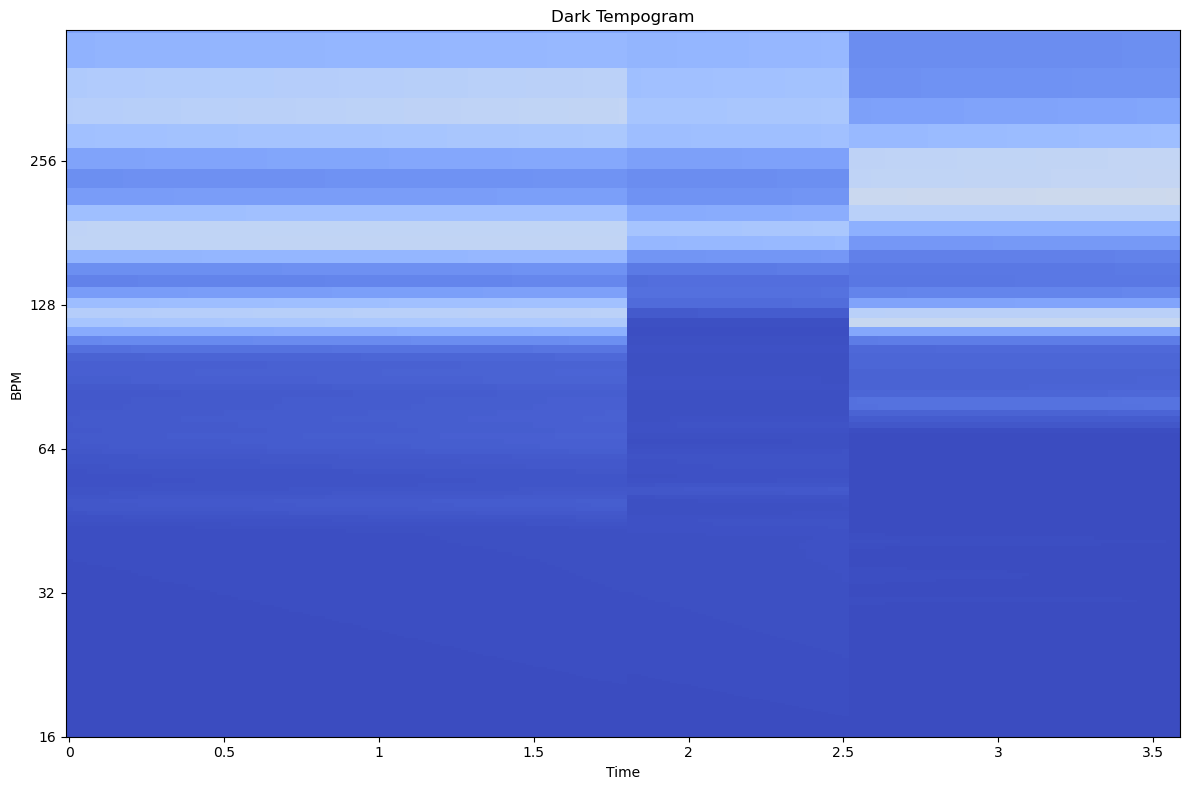

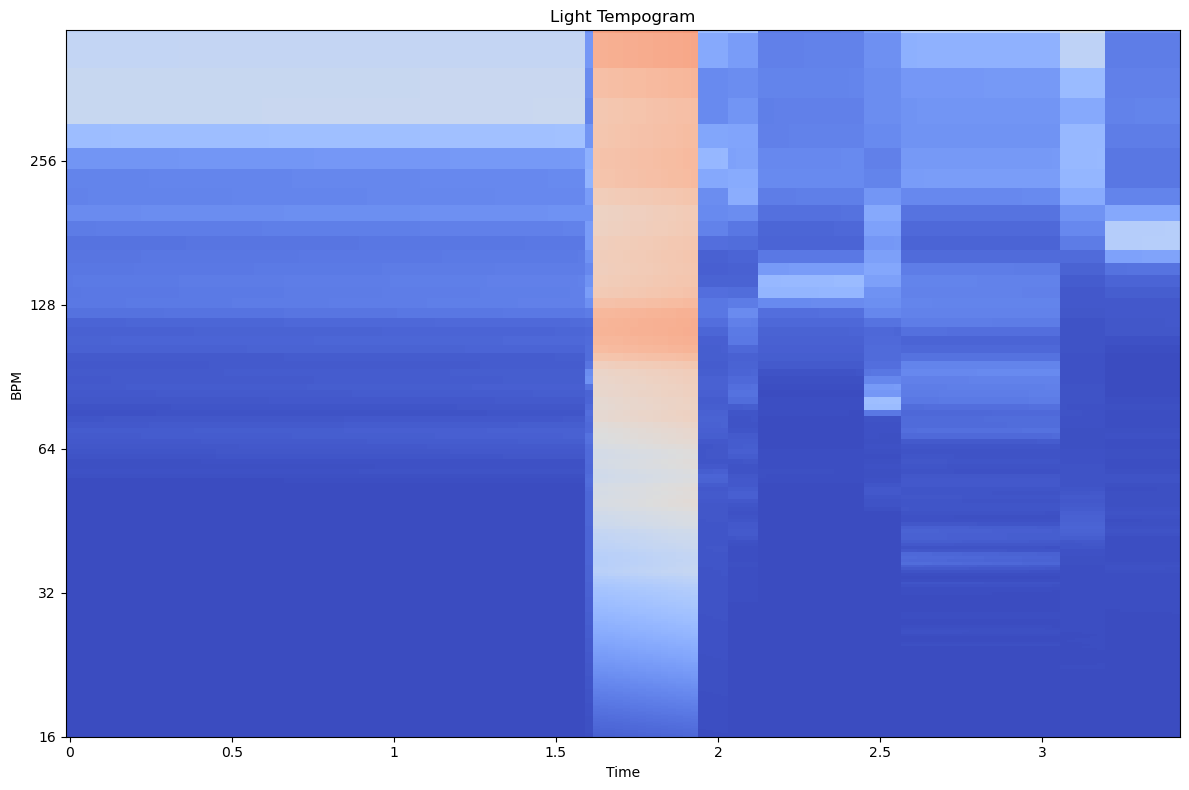

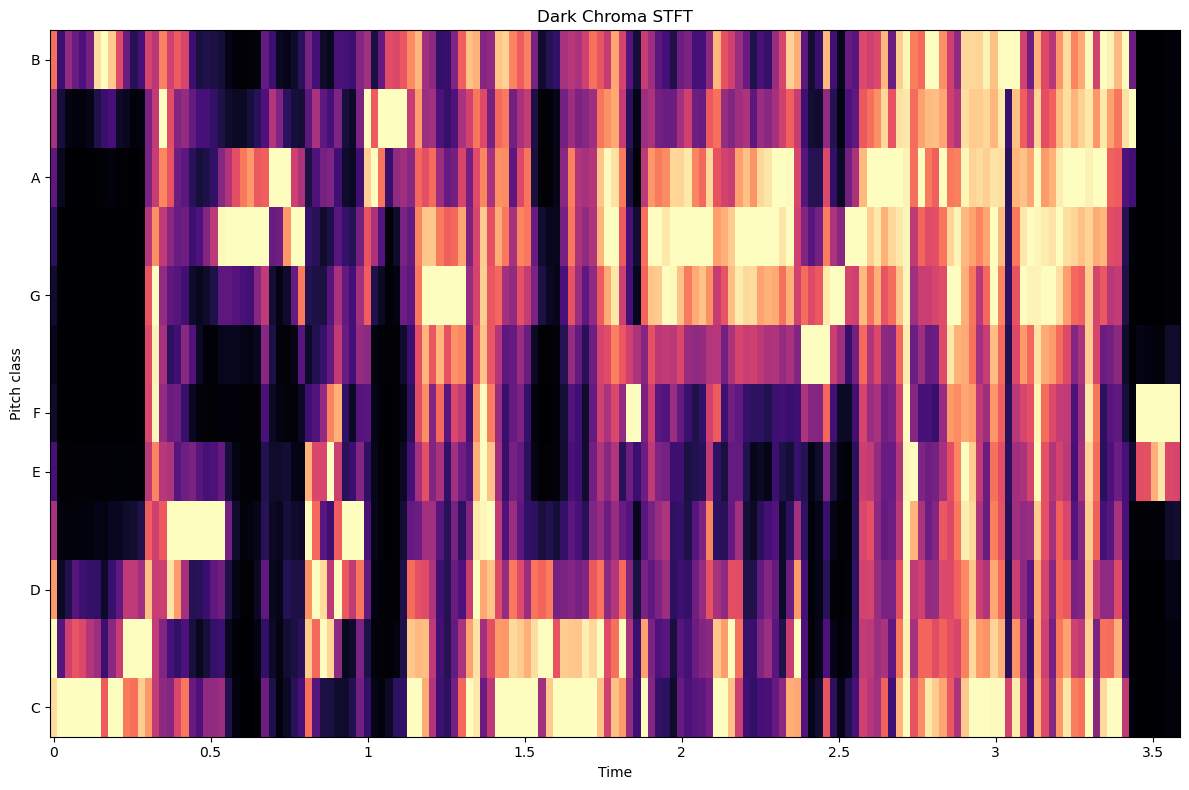

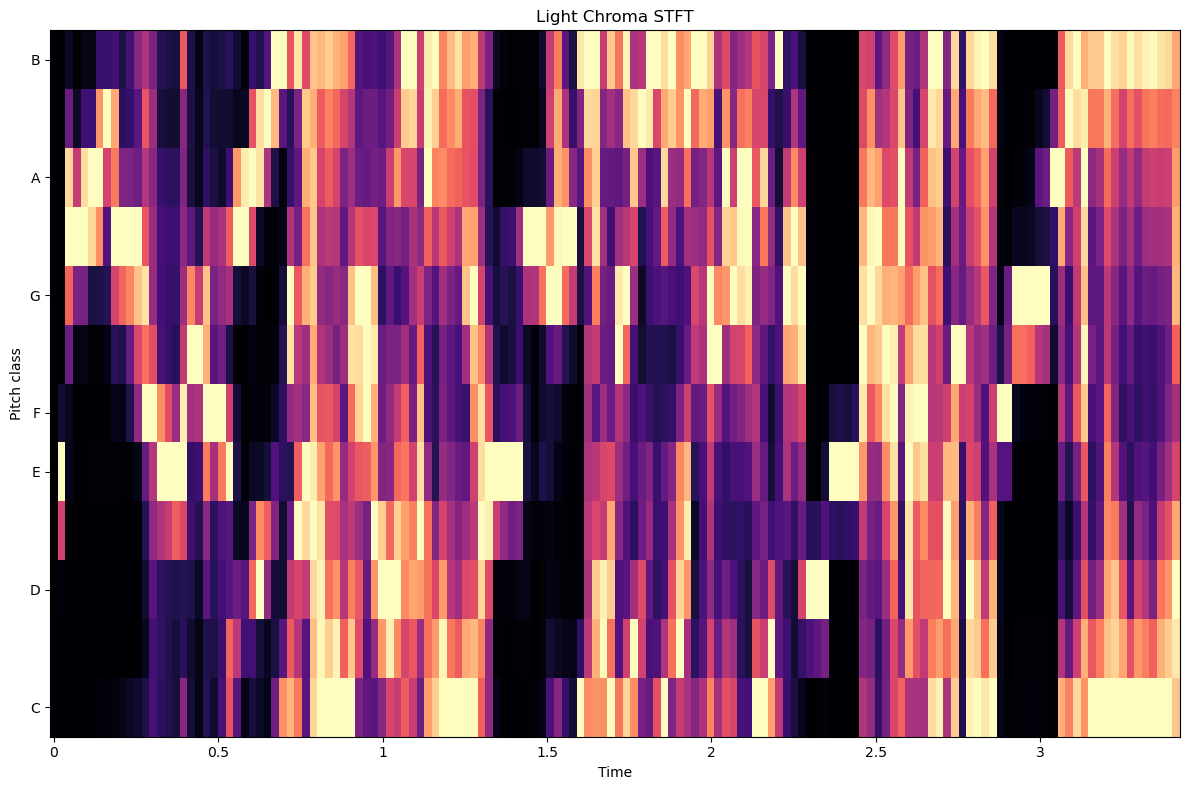

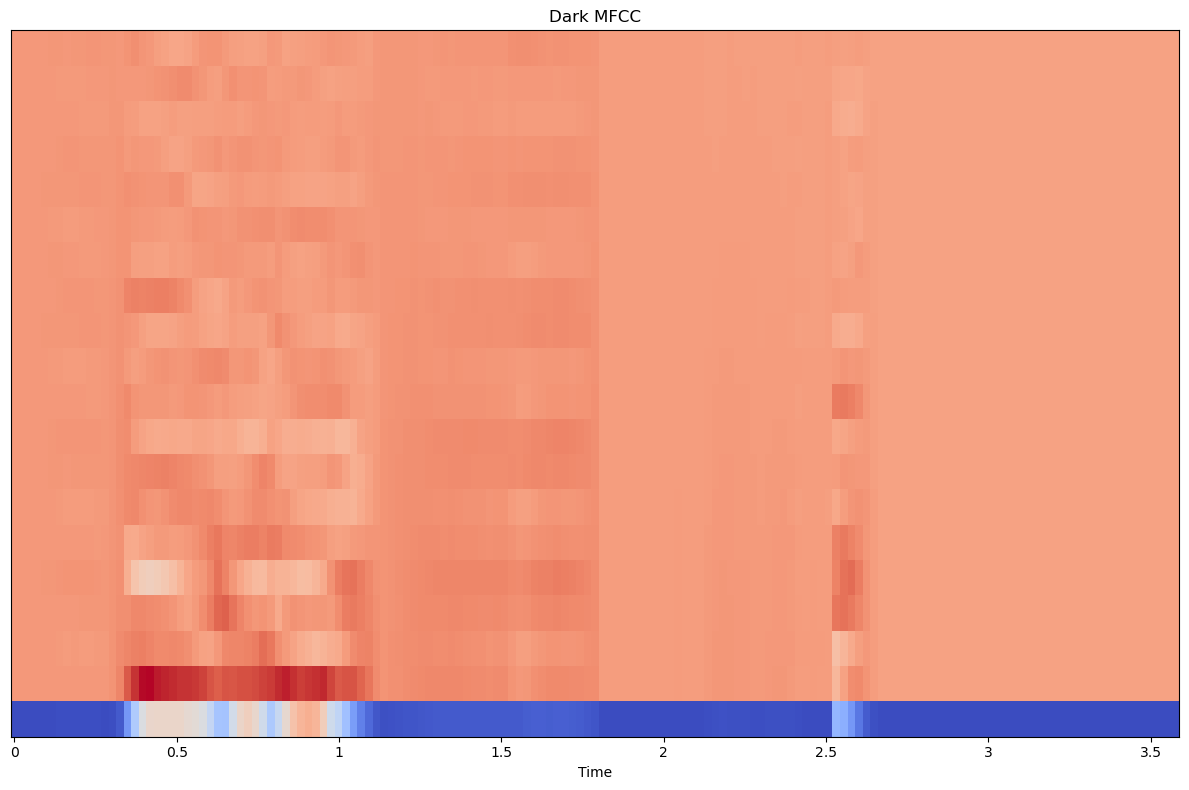

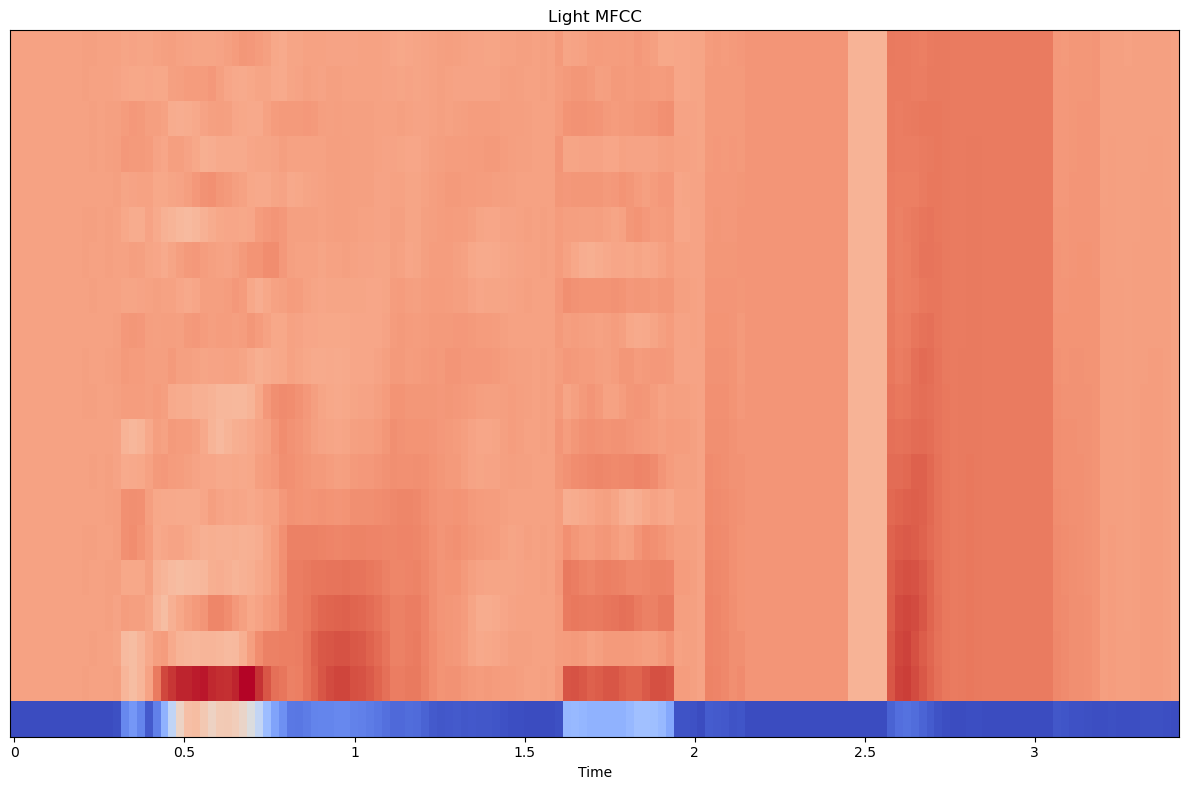

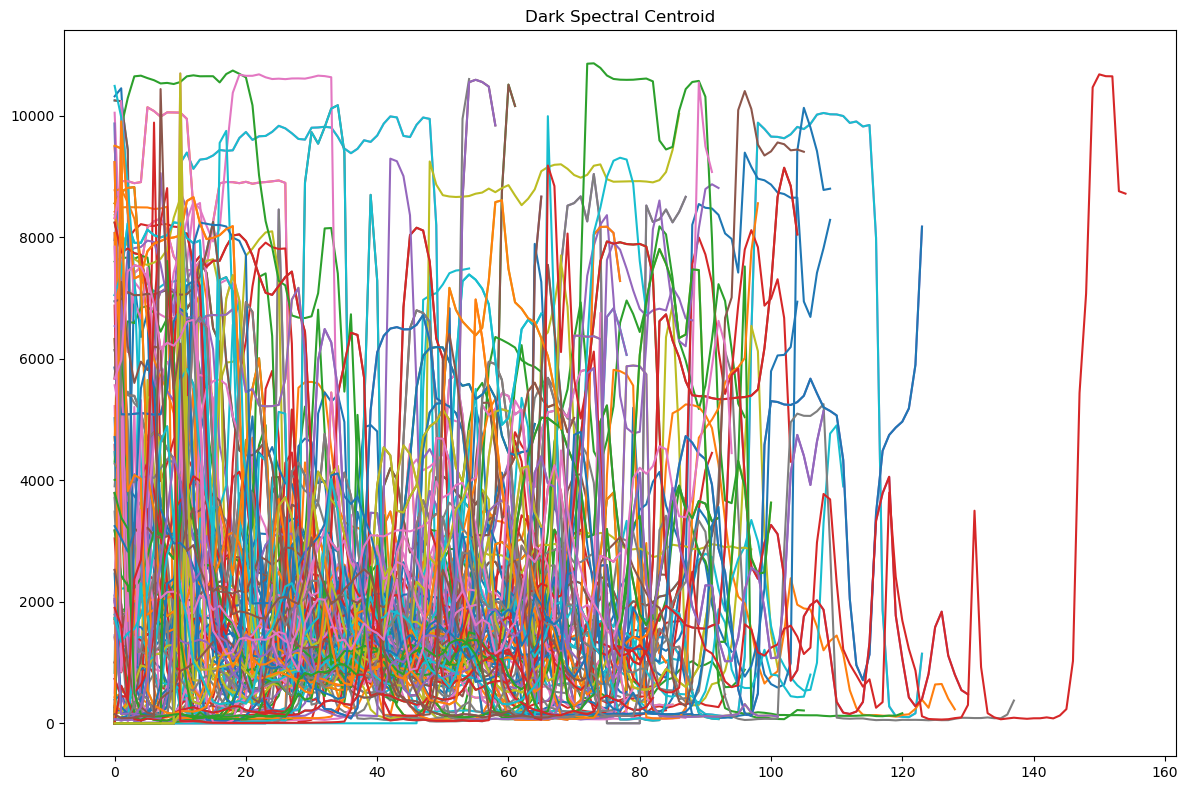

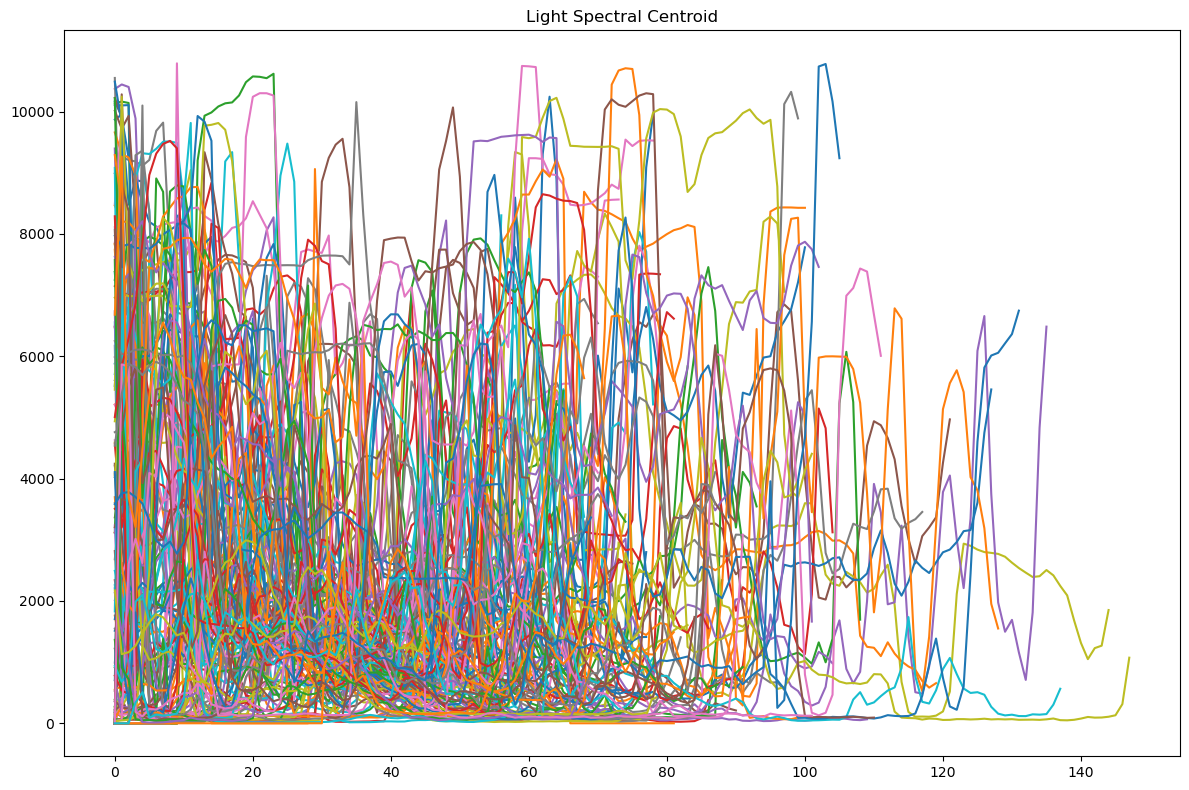

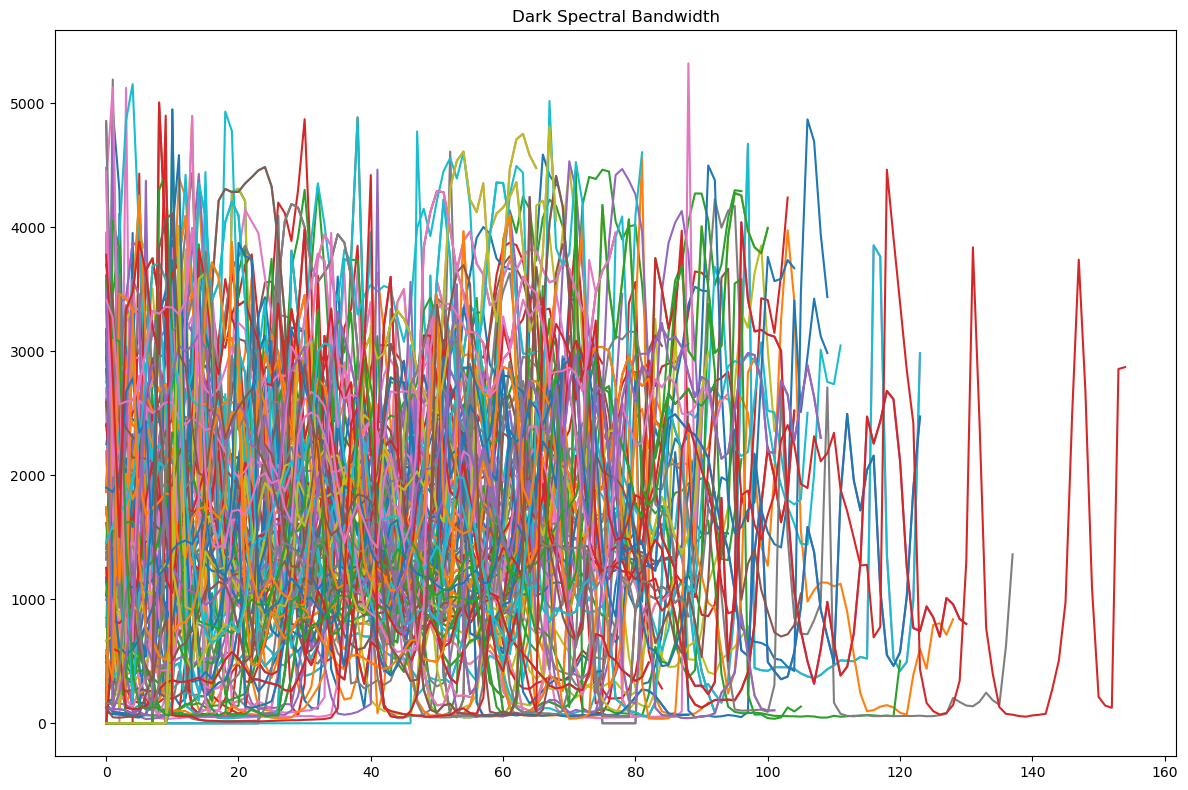

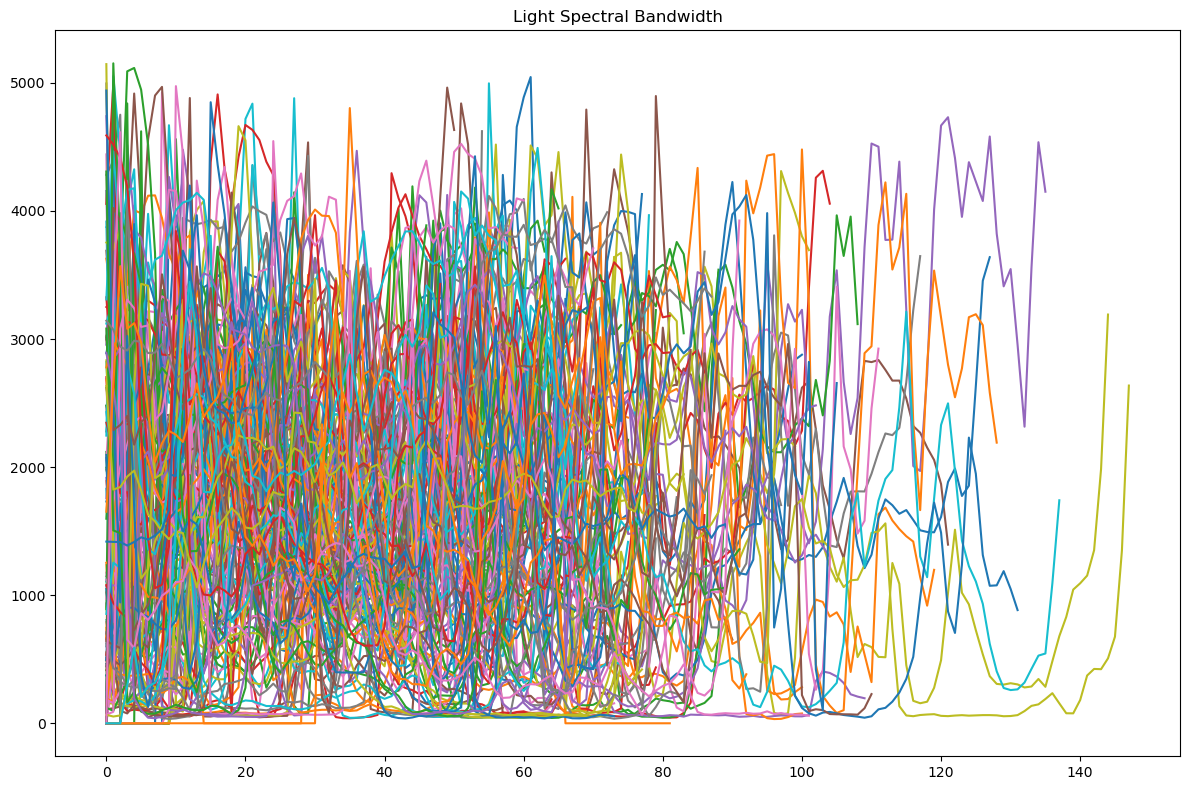

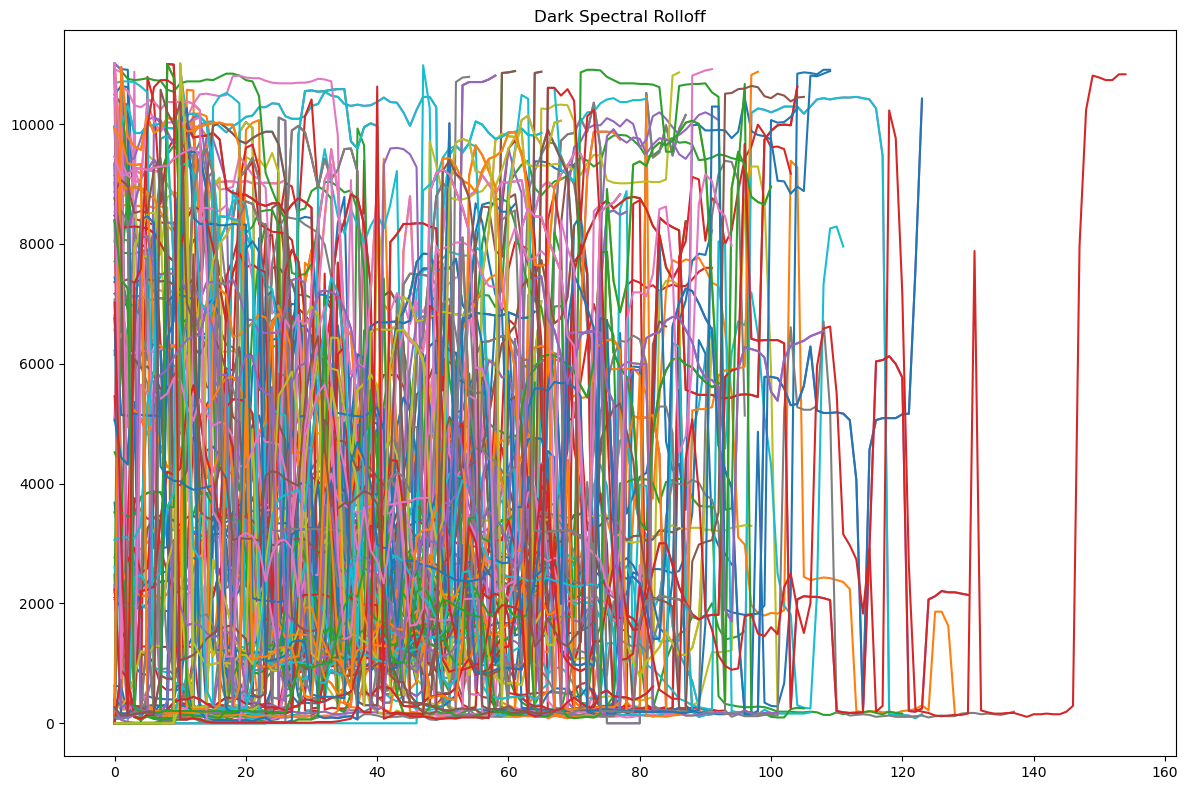

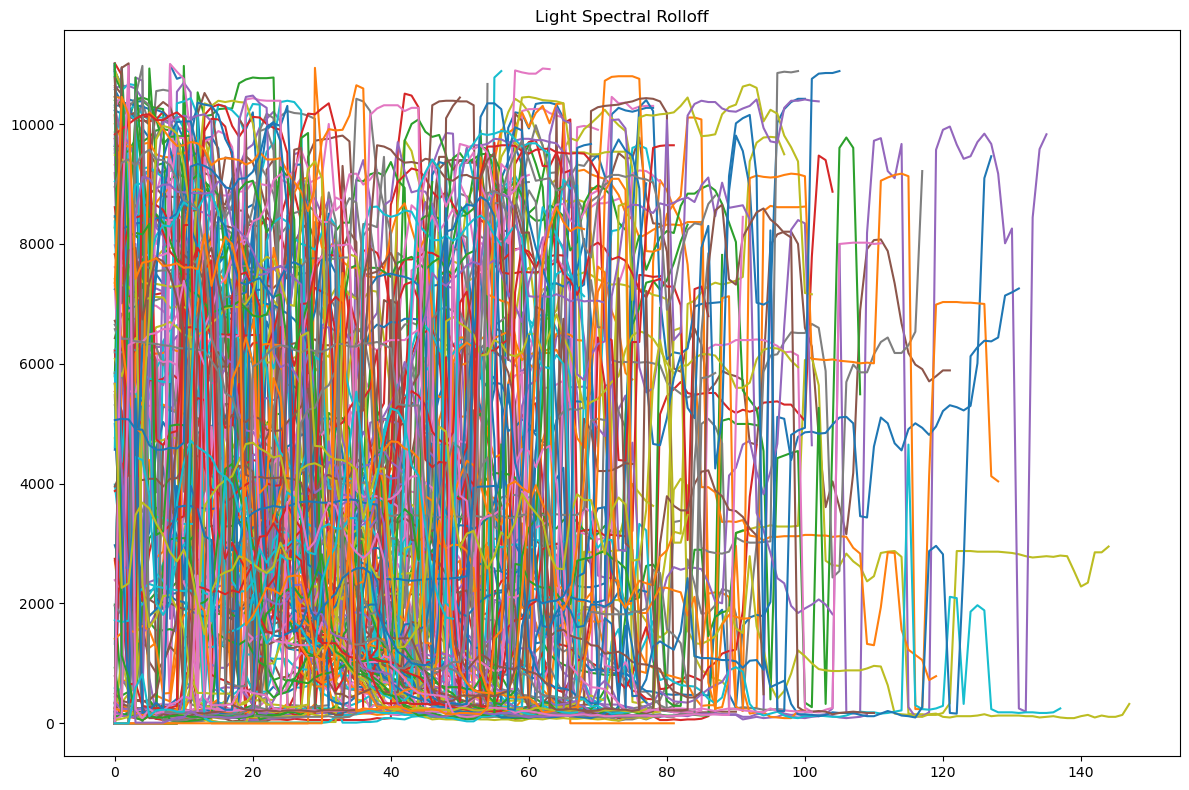

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        31
         1.0       0.90      0.90      0.90        31

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.90      0.90      0.90        62

Accuracy: 0.90
T-1.mp3: Light
T-10.mp3: Dark
T-2.mp3: Light
T-3.mp3: Dark
T-4.mp3: Dark
T-5.mp3: Light
T-6.mp3: Light
T-7.mp3: Dark
T-8.mp3: Light
T-9.mp3: Light


In [13]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score
import noisereduce as nr  # Make sure to install the noisereduce package

# Folder paths
dark_folder = "D:/EEE-309/Data_set/Train/Train_Dark"
light_folder = "D:/EEE-309/Data_set/Train/Train_Light"
test_folder = "D:/EEE-309/Data_set/EEE309_2_OL_Test_data"
TARGET_SR = 22050  # Target sampling rate

def load_audio_files(folder, num_files=None):
    """Load audio files from a folder."""
    files = os.listdir(folder)[:num_files]
    audio_data = []
    filenames = []
    for file in files:
        file_path = os.path.join(folder, file)
        try:
            audio, sr = librosa.load(file_path, sr=TARGET_SR)  # Resample to TARGET_SR
            audio_data.append((audio, sr))
            filenames.append(file)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
    return audio_data, filenames

def preprocess_audio(audio, sr):
    """Preprocess audio by removing noise and normalizing."""
    # Remove noise
    audio = nr.reduce_noise(y=audio, sr=sr)
    # Normalize audio
    audio = librosa.util.normalize(audio)
    return audio

def extract_features(audio_data):
    """Extract audio features from a list of (audio, sr) tuples."""
    tempograms, chroma_stfts, mfccs, centroids, bandwidths, rolloffs = [], [], [], [], [], []
    for audio, sr in audio_data:
        # Preprocess audio
        audio = preprocess_audio(audio, sr)
        tempograms.append(librosa.feature.tempogram(y=audio, sr=sr))
        chroma_stfts.append(librosa.feature.chroma_stft(y=audio, sr=sr))
        mfccs.append(librosa.feature.mfcc(y=audio, sr=sr))
        centroids.append(librosa.feature.spectral_centroid(y=audio, sr=sr)[0])
        bandwidths.append(librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0])
        rolloffs.append(librosa.feature.spectral_rolloff(y=audio, sr=sr)[0])
    return tempograms, chroma_stfts, mfccs, centroids, bandwidths, rolloffs

def plot_feature(feature, title, y_axis_label, sr, is_specshow=False):
    """Plot an audio feature."""
    plt.figure(figsize=(12, 8))
    plt.title(title)
    if is_specshow:
        for f in feature:
            librosa.display.specshow(f, sr=sr, x_axis='time', y_axis=y_axis_label)
    else:
        for f in feature:
            plt.plot(f)
    plt.tight_layout()
    plt.show()

# Load dark and light audio files
dark_audio_data, _ = load_audio_files(dark_folder)
light_audio_data, _ = load_audio_files(light_folder)

# Extract features
dark_tempograms, dark_chroma_stfts, dark_mfccs, dark_centroids, dark_bandwidths, dark_rolloffs = extract_features(dark_audio_data)
light_tempograms, light_chroma_stfts, light_mfccs, light_centroids, light_bandwidths, light_rolloffs = extract_features(light_audio_data)

# Plot features
plot_feature(dark_tempograms, 'Dark Tempogram', 'tempo', dark_audio_data[0][1], True)
plot_feature(light_tempograms, 'Light Tempogram', 'tempo', light_audio_data[0][1], True)
plot_feature(dark_chroma_stfts, 'Dark Chroma STFT', 'chroma', dark_audio_data[0][1], True)
plot_feature(light_chroma_stfts, 'Light Chroma STFT', 'chroma', light_audio_data[0][1], True)
plot_feature(dark_mfccs, 'Dark MFCC', None, dark_audio_data[0][1], True)
plot_feature(light_mfccs, 'Light MFCC', None, light_audio_data[0][1], True)
plot_feature(dark_centroids, 'Dark Spectral Centroid', None, dark_audio_data[0][1])
plot_feature(light_centroids, 'Light Spectral Centroid', None, light_audio_data[0][1])
plot_feature(dark_bandwidths, 'Dark Spectral Bandwidth', None, dark_audio_data[0][1])
plot_feature(light_bandwidths, 'Light Spectral Bandwidth', None, light_audio_data[0][1])
plot_feature(dark_rolloffs, 'Dark Spectral Rolloff', None, dark_audio_data[0][1])
plot_feature(light_rolloffs, 'Light Spectral Rolloff', None, light_audio_data[0][1])

# Feature extraction for model training
def extract_aggregated_features(audio_data):
    """Extract aggregated features from audio data."""
    features = []
    for audio, sr in audio_data:
        try:
            # Preprocess audio
            audio = preprocess_audio(audio, sr)
            tempogram = np.mean(librosa.feature.tempogram(y=audio, sr=sr), axis=1)
            chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)
            mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr), axis=1)
            centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr), axis=1)
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr), axis=1)
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr), axis=1)
            features.append(np.concatenate([tempogram, chroma_stft, mfcc, centroid, bandwidth, rolloff]))
        except Exception as e:
            print(f"Error processing audio data: {e}")
    return features

# Extract features for model
dark_features = extract_aggregated_features(dark_audio_data)
light_features = extract_aggregated_features(light_audio_data)

# Create labels
dark_labels = np.zeros(len(dark_features))
light_labels = np.ones(len(light_features))

# Combine features and labels
X = np.vstack((dark_features, light_features))
y = np.concatenate((dark_labels, light_labels))

# Shuffle and split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict and evaluate model on test data
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Load and preprocess test data
test_audio_data, test_filenames = load_audio_files(test_folder, num_files=None)  # Load all test files

# Extract features for test data
test_features = extract_aggregated_features(test_audio_data)

# Standardize test features
X_test_data = scaler.transform(test_features)

# Predict test data labels
test_predictions = svm.predict(X_test_data)

# Map numerical predictions to "Dark" or "Light"
label_map = {0.0: "Dark", 1.0: "Light"}
test_predictions_mapped = [label_map[pred] for pred in test_predictions]

# Print test data predictions with filenames
for filename, prediction in zip(test_filenames, test_predictions_mapped):
    print(f"{filename}: {prediction}")


C:\Users\compac market inc\AppData\Local\Temp\ipykernel_12760\2061149653.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=TARGET_SR)  # Resample to TARGET_SR
C:\Users\compac market inc\anaconda3\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


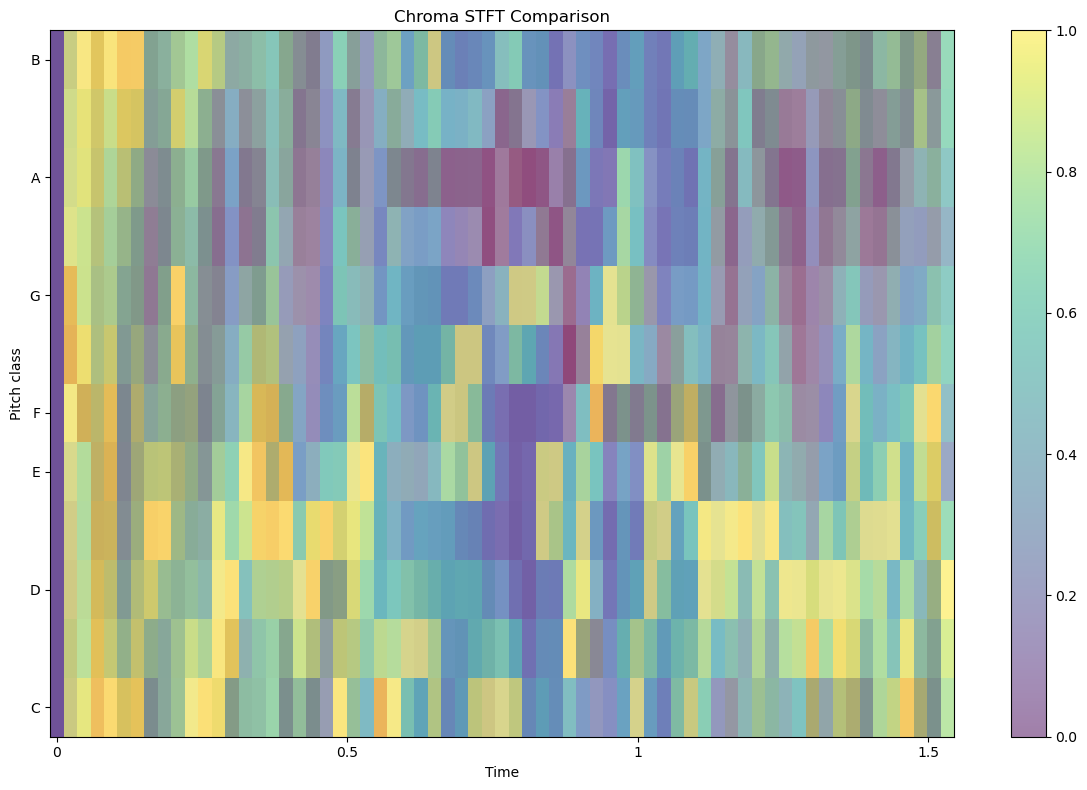

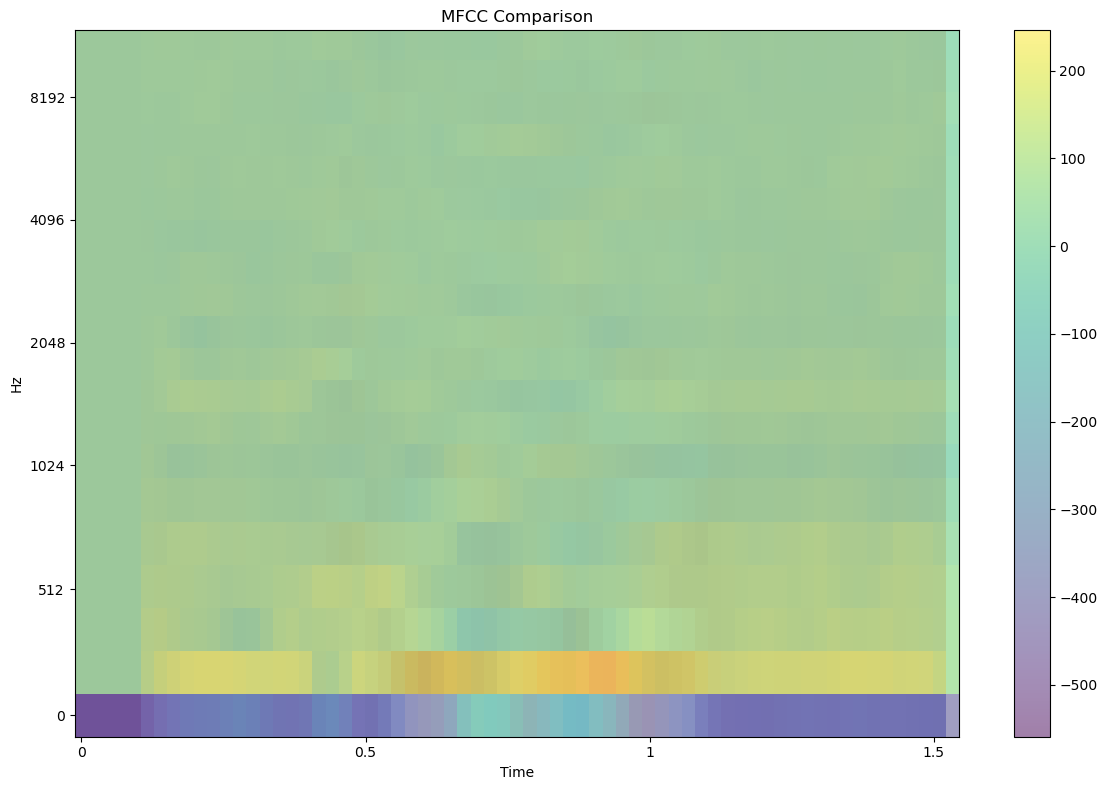

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        31
         1.0       0.90      0.90      0.90        31

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.90      0.90      0.90        62

Accuracy: 0.90


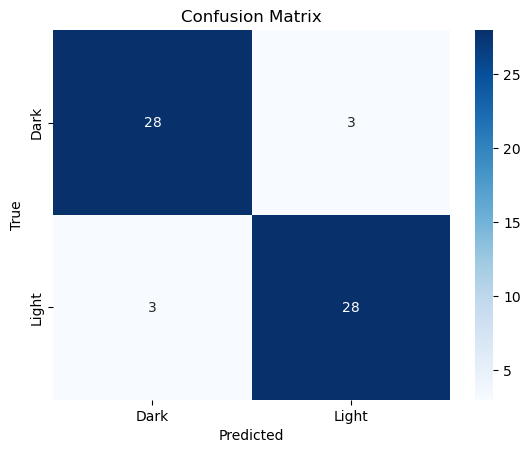

T-1.mp3: Light
T-10.mp3: Dark
T-2.mp3: Light
T-3.mp3: Dark
T-4.mp3: Dark
T-5.mp3: Light
T-6.mp3: Light
T-7.mp3: Dark
T-8.mp3: Light
T-9.mp3: Light


In [15]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import seaborn as sns
import noisereduce as nr  # Make sure to install the noisereduce package

# Folder paths
dark_folder = "D:/EEE-309/Data_set/Train/Train_Dark"
light_folder = "D:/EEE-309/Data_set/Train/Train_Light"
test_folder = "D:/EEE-309/Data_set/EEE309_2_OL_Test_data"
TARGET_SR = 22050  # Target sampling rate

def load_audio_files(folder, num_files=None):
    """Load audio files from a folder."""
    files = os.listdir(folder)[:num_files]
    audio_data = []
    filenames = []
    for file in files:
        file_path = os.path.join(folder, file)
        try:
            audio, sr = librosa.load(file_path, sr=TARGET_SR)  # Resample to TARGET_SR
            audio_data.append((audio, sr))
            filenames.append(file)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
    return audio_data, filenames

def preprocess_audio(audio, sr):
    """Preprocess audio by removing noise and normalizing."""
    # Remove noise
    audio = nr.reduce_noise(y=audio, sr=sr)
    # Normalize audio
    audio = librosa.util.normalize(audio)
    return audio

def extract_features(audio_data):
    """Extract audio features from a list of (audio, sr) tuples."""
    tempograms, chroma_stfts, mfccs, centroids, bandwidths, rolloffs = [], [], [], [], [], []
    for audio, sr in audio_data:
        # Preprocess audio
        audio = preprocess_audio(audio, sr)
        tempograms.append(librosa.feature.tempogram(y=audio, sr=sr))
        chroma_stfts.append(librosa.feature.chroma_stft(y=audio, sr=sr))
        mfccs.append(librosa.feature.mfcc(y=audio, sr=sr))
        centroids.append(librosa.feature.spectral_centroid(y=audio, sr=sr)[0])
        bandwidths.append(librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0])
        rolloffs.append(librosa.feature.spectral_rolloff(y=audio, sr=sr)[0])
    return tempograms, chroma_stfts, mfccs, centroids, bandwidths, rolloffs

# Feature extraction for model training
def extract_aggregated_features(audio_data):
    """Extract aggregated features from audio data."""
    features = []
    for audio, sr in audio_data:
        try:
            # Preprocess audio
            audio = preprocess_audio(audio, sr)
            tempogram = np.mean(librosa.feature.tempogram(y=audio, sr=sr), axis=1)
            chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)
            mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr), axis=1)
            centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr), axis=1)
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr), axis=1)
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr), axis=1)
            features.append(np.concatenate([tempogram, chroma_stft, mfcc, centroid, bandwidth, rolloff]))
        except Exception as e:
            print(f"Error processing audio data: {e}")
    return features

# Load dark and light audio files
dark_audio_data, _ = load_audio_files(dark_folder)
light_audio_data, _ = load_audio_files(light_folder)

# Extract features
dark_tempograms, dark_chroma_stfts, dark_mfccs, dark_centroids, dark_bandwidths, dark_rolloffs = extract_features(dark_audio_data)
light_tempograms, light_chroma_stfts, light_mfccs, light_centroids, light_bandwidths, light_rolloffs = extract_features(light_audio_data)

# Plot Chroma STFT for Dark and Light audio
plt.figure(figsize=(12, 8))
plt.title('Chroma STFT Comparison')
librosa.display.specshow(dark_chroma_stfts[0], sr=dark_audio_data[0][1], x_axis='time', y_axis='chroma', cmap='coolwarm', alpha=0.5)
librosa.display.specshow(light_chroma_stfts[0], sr=light_audio_data[0][1], x_axis='time', y_axis='chroma', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

# Plot MFCC for Dark and Light audio
plt.figure(figsize=(12, 8))
plt.title('MFCC Comparison')
librosa.display.specshow(dark_mfccs[0], sr=dark_audio_data[0][1], x_axis='time', y_axis='mel', cmap='coolwarm', alpha=0.5)
librosa.display.specshow(light_mfccs[0], sr=light_audio_data[0][1], x_axis='time', y_axis='mel', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

# Extract aggregated features for model
dark_features = extract_aggregated_features(dark_audio_data)
light_features = extract_aggregated_features(light_audio_data)

# Create labels
dark_labels = np.zeros(len(dark_features))
light_labels = np.ones(len(light_features))

# Combine features and labels
X = np.vstack((dark_features, light_features))
y = np.concatenate((dark_labels, light_labels))

# Shuffle and split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM model
svm = SVC(kernel='linear')
svm.fit(X_train, y_train)

# Predict and evaluate model on test data
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Dark", "Light"], yticklabels=["Dark", "Light"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Load and preprocess test data
test_audio_data, test_filenames = load_audio_files(test_folder, num_files=None)  # Load all test files

# Extract features for test data
test_features = extract_aggregated_features(test_audio_data)

# Standardize test features
X_test_data = scaler.transform(test_features)

# Predict test data labels
test_predictions = svm.predict(X_test_data)

# Map numerical predictions to "Dark" or "Light"
label_map = {0.0: "Dark", 1.0: "Light"}
test_predictions_mapped = [label_map[pred] for pred in test_predictions]

# Print test data predictions with filenames
for filename, prediction in zip(test_filenames, test_predictions_mapped):
    print(f"{filename}: {prediction}")


C:\Users\compac market inc\AppData\Local\Temp\ipykernel_12760\397448275.py:27: UserWarning: PySoundFile failed. Trying audioread instead.
  audio, sr = librosa.load(file_path, sr=TARGET_SR)  # Resample to TARGET_SR
C:\Users\compac market inc\anaconda3\Lib\site-packages\librosa\core\audio.py:183: FutureWarning: librosa.core.audio.__audioread_load
	Deprecated as of librosa version 0.10.0.
	It will be removed in librosa version 1.0.
  y, sr_native = __audioread_load(path, offset, duration, dtype)


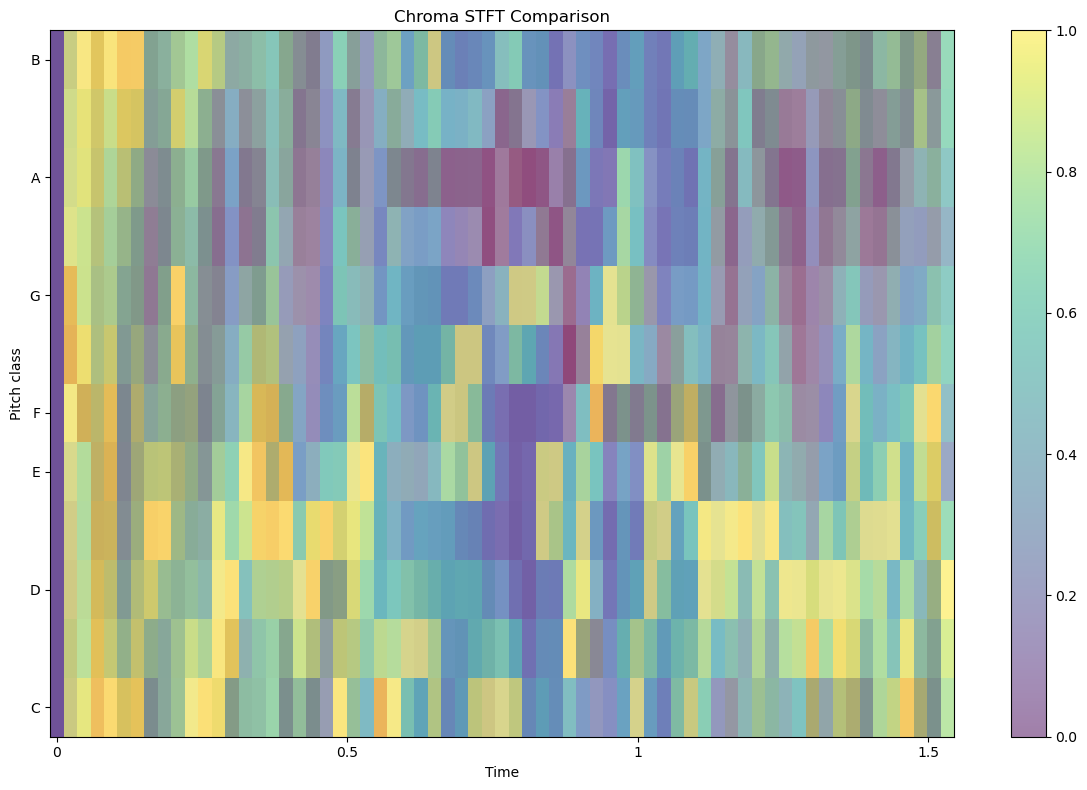

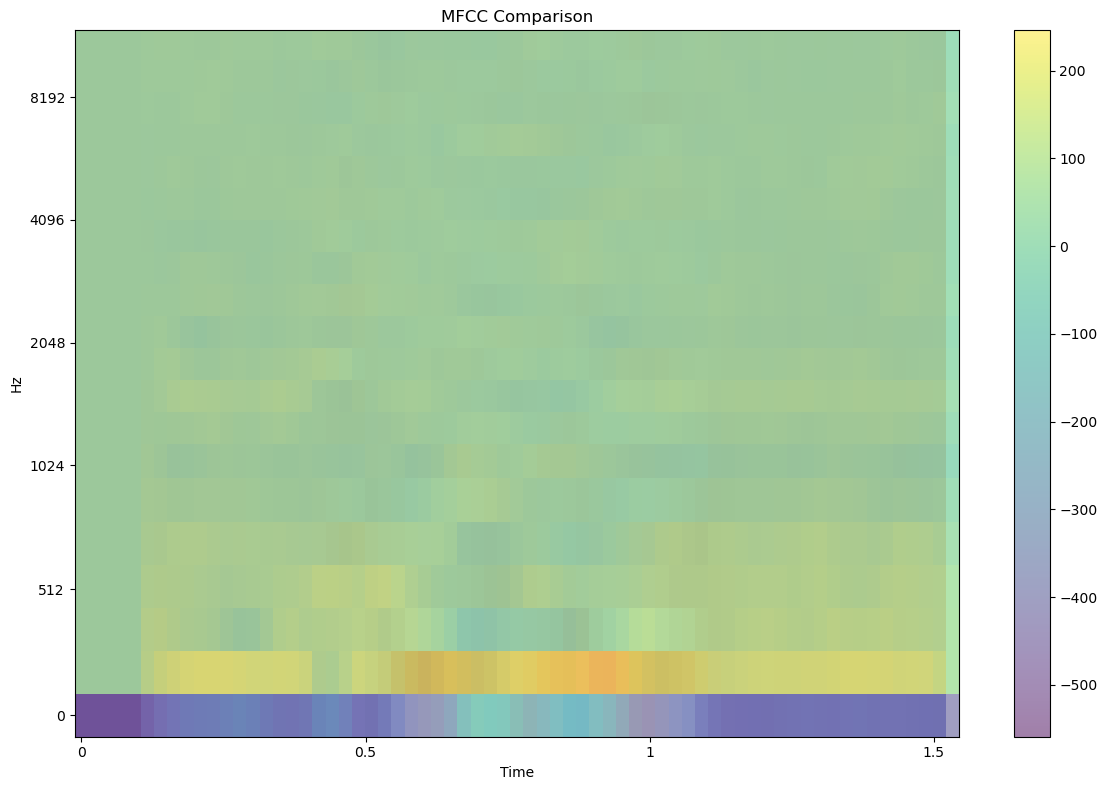

              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90        31
         1.0       0.90      0.90      0.90        31

    accuracy                           0.90        62
   macro avg       0.90      0.90      0.90        62
weighted avg       0.90      0.90      0.90        62

Accuracy: 0.90


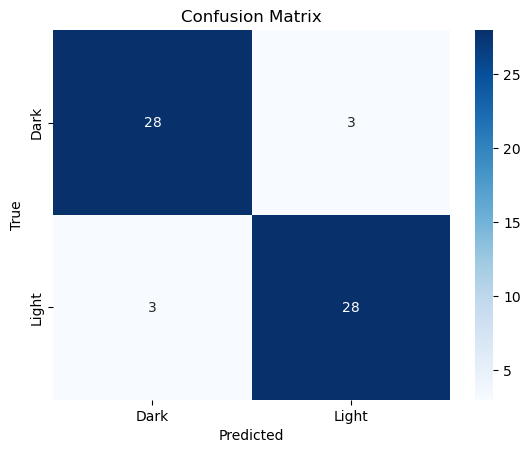

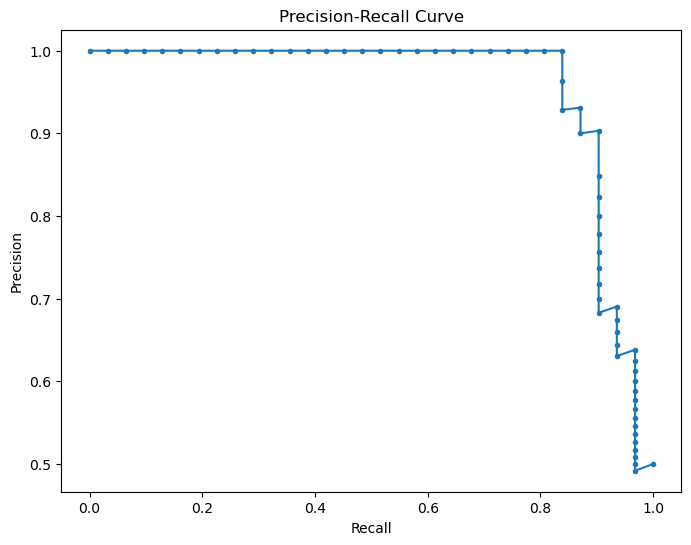

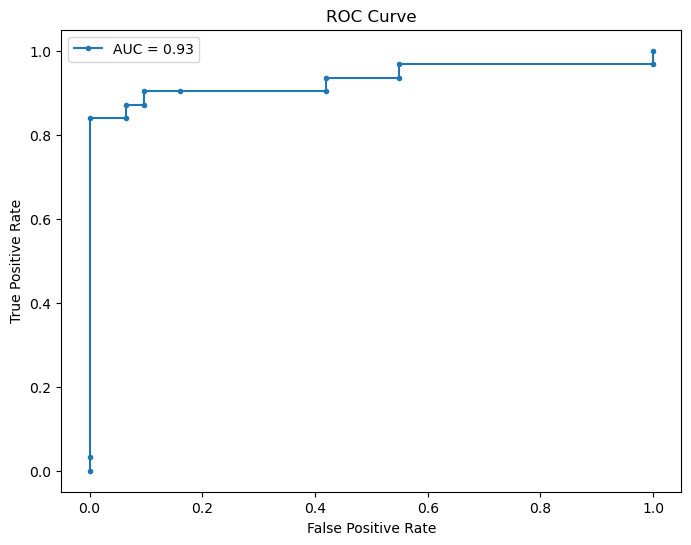

T-1.mp3: Light
T-10.mp3: Dark
T-2.mp3: Light
T-3.mp3: Dark
T-4.mp3: Dark
T-5.mp3: Light
T-6.mp3: Light
T-7.mp3: Dark
T-8.mp3: Light
T-9.mp3: Light


In [16]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix, precision_recall_curve, roc_curve, auc
import seaborn as sns
import noisereduce as nr  # Make sure to install the noisereduce package

# Folder paths
dark_folder = "D:/EEE-309/Data_set/Train/Train_Dark"
light_folder = "D:/EEE-309/Data_set/Train/Train_Light"
test_folder = "D:/EEE-309/Data_set/EEE309_2_OL_Test_data"
TARGET_SR = 22050  # Target sampling rate

def load_audio_files(folder, num_files=None):
    """Load audio files from a folder."""
    files = os.listdir(folder)[:num_files]
    audio_data = []
    filenames = []
    for file in files:
        file_path = os.path.join(folder, file)
        try:
            audio, sr = librosa.load(file_path, sr=TARGET_SR)  # Resample to TARGET_SR
            audio_data.append((audio, sr))
            filenames.append(file)
        except Exception as e:
            print(f"Error loading file {file_path}: {e}")
    return audio_data, filenames

def preprocess_audio(audio, sr):
    """Preprocess audio by removing noise and normalizing."""
    # Remove noise
    audio = nr.reduce_noise(y=audio, sr=sr)
    # Normalize audio
    audio = librosa.util.normalize(audio)
    return audio

def extract_features(audio_data):
    """Extract audio features from a list of (audio, sr) tuples."""
    tempograms, chroma_stfts, mfccs, centroids, bandwidths, rolloffs = [], [], [], [], [], []
    for audio, sr in audio_data:
        # Preprocess audio
        audio = preprocess_audio(audio, sr)
        tempograms.append(librosa.feature.tempogram(y=audio, sr=sr))
        chroma_stfts.append(librosa.feature.chroma_stft(y=audio, sr=sr))
        mfccs.append(librosa.feature.mfcc(y=audio, sr=sr))
        centroids.append(librosa.feature.spectral_centroid(y=audio, sr=sr)[0])
        bandwidths.append(librosa.feature.spectral_bandwidth(y=audio, sr=sr)[0])
        rolloffs.append(librosa.feature.spectral_rolloff(y=audio, sr=sr)[0])
    return tempograms, chroma_stfts, mfccs, centroids, bandwidths, rolloffs

# Feature extraction for model training
def extract_aggregated_features(audio_data):
    """Extract aggregated features from audio data."""
    features = []
    for audio, sr in audio_data:
        try:
            # Preprocess audio
            audio = preprocess_audio(audio, sr)
            tempogram = np.mean(librosa.feature.tempogram(y=audio, sr=sr), axis=1)
            chroma_stft = np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1)
            mfcc = np.mean(librosa.feature.mfcc(y=audio, sr=sr), axis=1)
            centroid = np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr), axis=1)
            bandwidth = np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr), axis=1)
            rolloff = np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr), axis=1)
            features.append(np.concatenate([tempogram, chroma_stft, mfcc, centroid, bandwidth, rolloff]))
        except Exception as e:
            print(f"Error processing audio data: {e}")
    return features

# Load dark and light audio files
dark_audio_data, _ = load_audio_files(dark_folder)
light_audio_data, _ = load_audio_files(light_folder)

# Extract features
dark_tempograms, dark_chroma_stfts, dark_mfccs, dark_centroids, dark_bandwidths, dark_rolloffs = extract_features(dark_audio_data)
light_tempograms, light_chroma_stfts, light_mfccs, light_centroids, light_bandwidths, light_rolloffs = extract_features(light_audio_data)

# Plot Chroma STFT for Dark and Light audio
plt.figure(figsize=(12, 8))
plt.title('Chroma STFT Comparison')
librosa.display.specshow(dark_chroma_stfts[0], sr=dark_audio_data[0][1], x_axis='time', y_axis='chroma', cmap='coolwarm', alpha=0.5)
librosa.display.specshow(light_chroma_stfts[0], sr=light_audio_data[0][1], x_axis='time', y_axis='chroma', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

# Plot MFCC for Dark and Light audio
plt.figure(figsize=(12, 8))
plt.title('MFCC Comparison')
librosa.display.specshow(dark_mfccs[0], sr=dark_audio_data[0][1], x_axis='time', y_axis='mel', cmap='coolwarm', alpha=0.5)
librosa.display.specshow(light_mfccs[0], sr=light_audio_data[0][1], x_axis='time', y_axis='mel', cmap='viridis', alpha=0.5)
plt.colorbar()
plt.tight_layout()
plt.show()

# Extract aggregated features for model
dark_features = extract_aggregated_features(dark_audio_data)
light_features = extract_aggregated_features(light_audio_data)

# Create labels
dark_labels = np.zeros(len(dark_features))
light_labels = np.ones(len(light_features))

# Combine features and labels
X = np.vstack((dark_features, light_features))
y = np.concatenate((dark_labels, light_labels))

# Shuffle and split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Standardize features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Train SVM model
svm = SVC(kernel='linear', probability=True)
svm.fit(X_train, y_train)

# Predict and evaluate model on test data
y_pred = svm.predict(X_test)
print(classification_report(y_test, y_pred))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.2f}")

# Confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=["Dark", "Light"], yticklabels=["Dark", "Light"])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

# Precision-Recall curve
y_scores = svm.decision_function(X_test)
precision, recall, _ = precision_recall_curve(y_test, y_scores)
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.show()

# ROC curve
fpr, tpr, _ = roc_curve(y_test, y_scores)
roc_auc = auc(fpr, tpr)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, marker='.', label=f'AUC = {roc_auc:.2f}')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Load and preprocess test data
test_audio_data, test_filenames = load_audio_files(test_folder, num_files=None)  # Load all test files

# Extract features for test data
test_features = extract_aggregated_features(test_audio_data)

# Standardize test features
X_test_data = scaler.transform(test_features)

# Predict test data labels
test_predictions = svm.predict(X_test_data)

# Map numerical predictions to "Dark" or "Light"
label_map = {0.0: "Dark", 1.0: "Light"}
test_predictions_mapped = [label_map[pred] for pred in test_predictions]

# Print test data predictions with filenames
for filename, prediction in zip(test_filenames, test_predictions_mapped):
    print(f"{filename}: {prediction}")


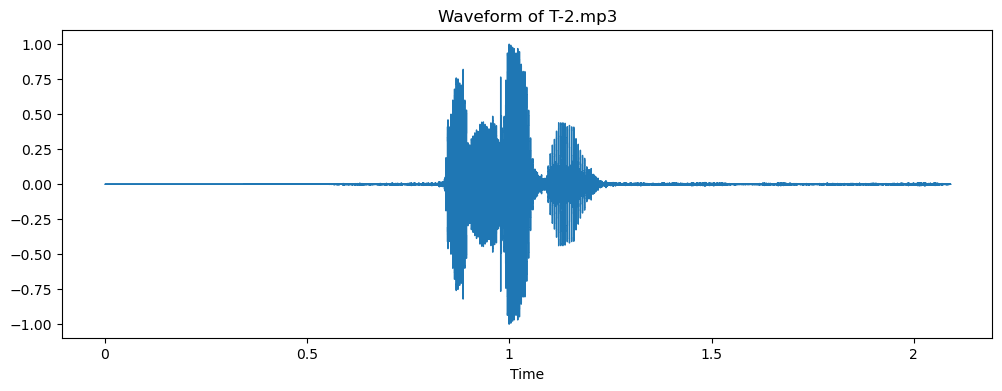

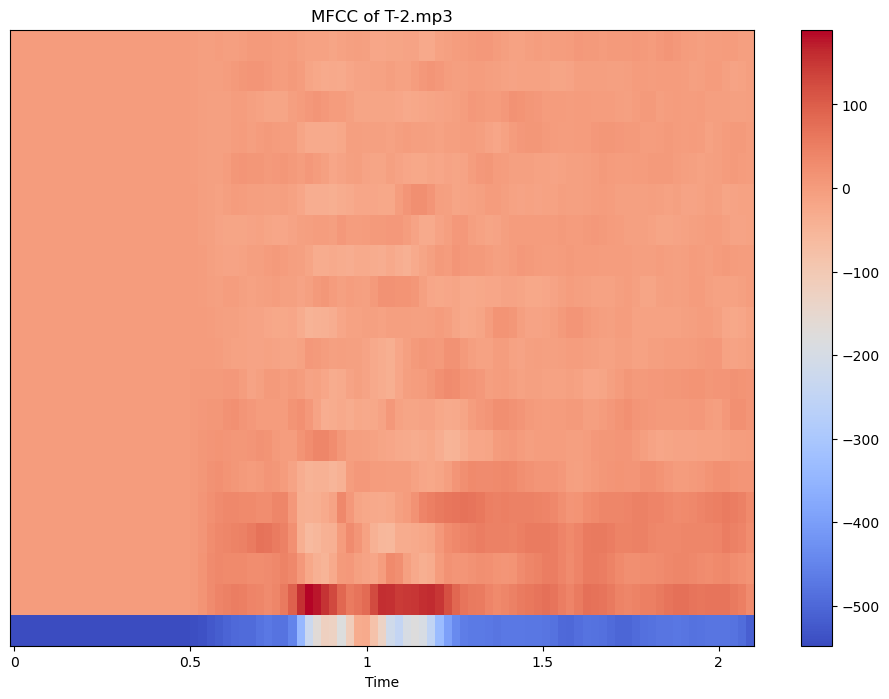

In [17]:
# Load the T-2.mp3 file
file_path = os.path.join(test_folder, 'T-2.mp3')
audio, sr = librosa.load(file_path, sr=TARGET_SR)

# Preprocess the audio
audio = preprocess_audio(audio, sr)

# Plot the waveform
plt.figure(figsize=(12, 4))
librosa.display.waveshow(audio, sr=sr)
plt.title('Waveform of T-2.mp3')
plt.show()

# Extract and plot the features
mfcc = librosa.feature.mfcc(y=audio, sr=sr)
plt.figure(figsize=(12, 8))
librosa.display.specshow(mfcc, sr=sr, x_axis='time')
plt.colorbar()
plt.title('MFCC of T-2.mp3')
plt.show()


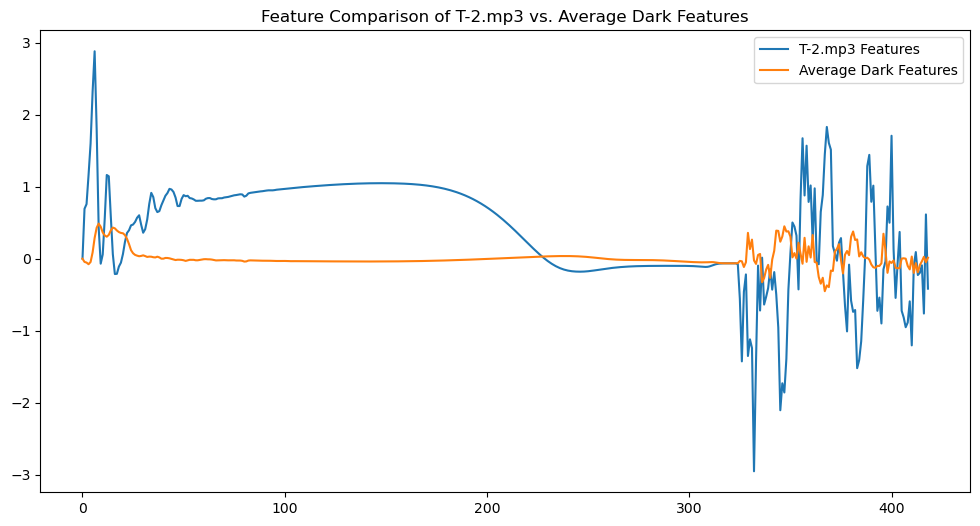

In [18]:
# Extract features for T-2.mp3
t2_features = np.concatenate([
    np.mean(librosa.feature.tempogram(y=audio, sr=sr), axis=1),
    np.mean(librosa.feature.chroma_stft(y=audio, sr=sr), axis=1),
    np.mean(librosa.feature.mfcc(y=audio, sr=sr), axis=1),
    np.mean(librosa.feature.spectral_centroid(y=audio, sr=sr), axis=1),
    np.mean(librosa.feature.spectral_bandwidth(y=audio, sr=sr), axis=1),
    np.mean(librosa.feature.spectral_rolloff(y=audio, sr=sr), axis=1)
])

# Standardize the T-2 features
t2_features_scaled = scaler.transform([t2_features])

# Calculate the average features for the Dark class
dark_features_mean = np.mean(X_train[y_train == 0], axis=0)

# Plot a comparison
plt.figure(figsize=(12, 6))
plt.plot(t2_features_scaled[0], label='T-2.mp3 Features')
plt.plot(dark_features_mean, label='Average Dark Features')
plt.legend()
plt.title('Feature Comparison of T-2.mp3 vs. Average Dark Features')
plt.show()


Decision function value for T-2.mp3: [0.65569445]


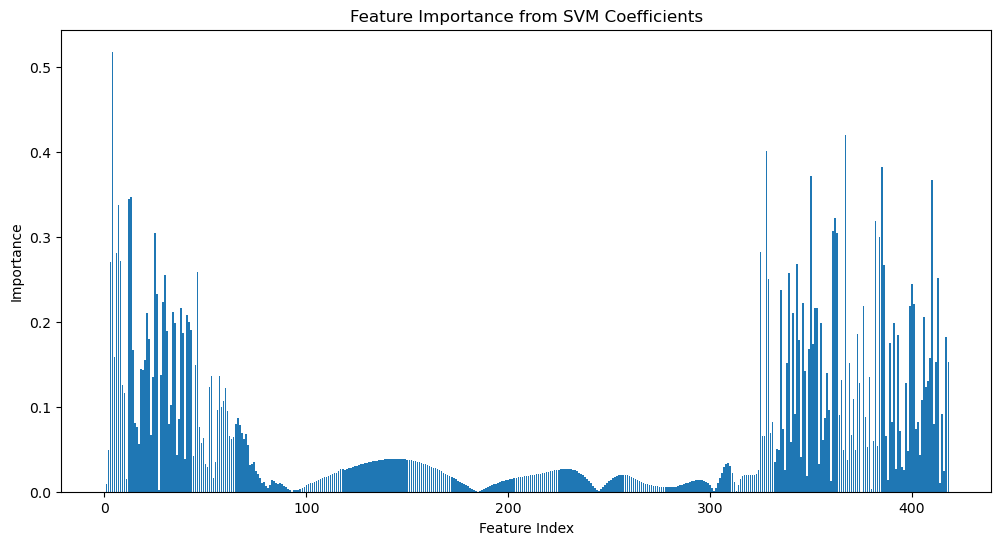

In [19]:
# Get the decision function value for T-2.mp3
t2_decision_function = svm.decision_function(t2_features_scaled)

print(f"Decision function value for T-2.mp3: {t2_decision_function}")

# Investigate which features are most important
coef = svm.coef_[0]
feature_importance = np.abs(coef)

plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title('Feature Importance from SVM Coefficients')
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.show()


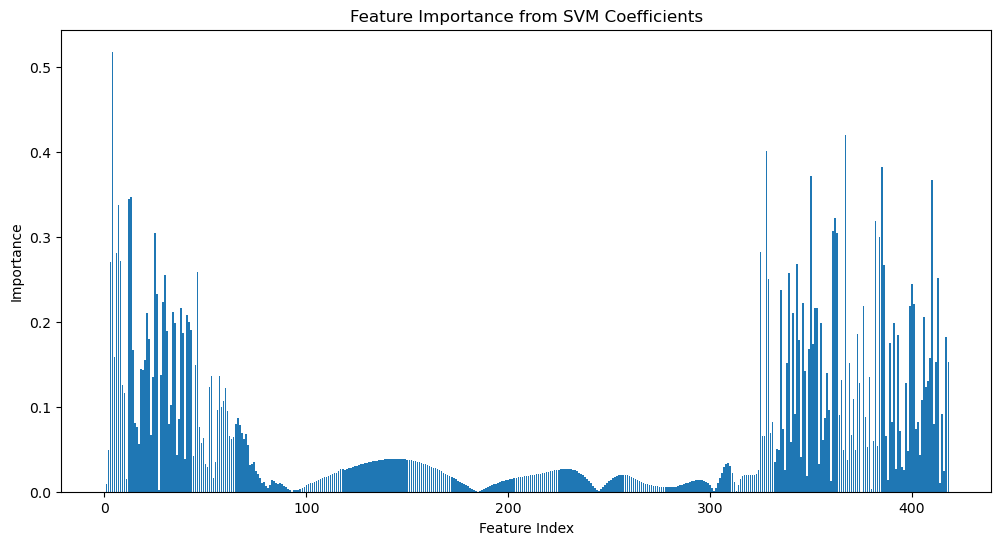

In [21]:
feature_importance = np.abs(svm.coef_).flatten()
plt.figure(figsize=(12, 6))
plt.bar(range(len(feature_importance)), feature_importance)
plt.title("Feature Importance from SVM Coefficients")
plt.xlabel("Feature Index")
plt.ylabel("Importance")
plt.show()
